In [110]:
import os
# Set the environment variable to disable hash randomization
os.environ['PYTHONHASHSEED'] = '0'
#If you find discrepancies between the UMAP and Leiden results, indicating reproducibility issues, 
#please refer to this link: https://github.com/scverse/scanpy/issues/1009 for potential solutions.
#https://umap-learn.readthedocs.io/en/latest/reproducibility.html
# set export OMP_NUM_THREADS=1 Multithreading can lead to reproducibility issues!!!
#Theoretically, minor differences in UMAP and inconsistencies in Leiden clustering do not affect their biological significance.
import scanpy as  sc
import anndata as ad
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import seaborn as sns
import scanpy.external as sce
import loompy
import harmonypy as hm
print('import successful')

import successful


In [111]:
###global variable###

In [112]:
PCs = 20
res = 0.3
top_genes=2000
dataset = 'M-SG'
h5adpath = f'../0.loom/{dataset}_for_subset.h5ad'
celltypelist = ['Luminal epithelial cells','Basal epithelial cells','Proliferating epithelial cells','Keratinized epithelial cells']
vars_use=['sample']
NewCellType = {
    "StemCells": [2,4,7,6,10]
}
update_cell_type = False
clusterlist = ['']
Featuregenes = ['Esr1','Epcam','Lalba','Top2a','Pgr','Prlr','Acta2','Elf5','Tcf4','Krt1','Ar','Pigr','Cd69','Adipoq','Lum','Vim','Ptprc','Lef1','Tpm2','Krt23','Krt10','Faah','Tm4sf1','Ppl','Wnt11','Krtdap','Sbsn','Dsp','Rab25','Aqp3','Shh','Atp1a1','Atp1b1','Procr']
random.seed(2024)
np.random.seed(2024)
cells = 5000
doFeatureplot = True
runharmony = True
subset_celltype = True
do_subset_cluster = False
random_subset_cells = False
use_scvi=False

In [113]:
###################function###############

In [114]:
def update_cell_annotations(adata, clustering_column, new_cell_type_dict, update_cell_type):
    if not update_cell_type:
        print("细胞注释更新被禁用")
        return adata


    cluster_to_celltype = {}

    for cell_type, clusters in new_cell_type_dict.items():
        for cluster in clusters:
            cluster_to_celltype[str(cluster)] = cell_type
    adata.obs['subtype'] = adata.obs[clustering_column].map(cluster_to_celltype)

    print("finish updata_cell_annotation")
    print(adata.obs['subtype'].value_counts())
    print(adata.obs['celltype'].value_counts())
    return adata

In [115]:
def run_harmony(adata,vars_use=vars_use):
    print('running harmony')
    pca_result = adata.obsm['X_pca']
    ho = hm.run_harmony(pca_result, adata.obs, vars_use,random_state=42)
    adata.obsm['X_pca_harmony'] = ho.Z_corr.T
    print('finished harmony')
    return adata

In [116]:
def random_subset(adata,n_cells):
    print(f"random subset cells {n_cells}")
    random_indices = np.random.choice(adata.n_obs, size=n_cells, replace=False)
    adata_sub = adata[random_indices, :]
    return adata_sub

In [117]:
def export_deg_result(adata):
    result = adata.uns['rank_genes_groups']
    groups = result['names'].dtype.names
    data = []
    for group in groups:
        genes = result['names'][group]
        logfoldchanges = result['logfoldchanges'][group]
        pvals = result['pvals'][group]
        pvals_adj = result['pvals_adj'][group]
        for gene, lfc, pval, pval_adj in zip(genes, logfoldchanges, pvals, pvals_adj):
            data.append([group, gene, lfc, pval, pval_adj])
    df = pd.DataFrame(data, columns=['group', 'gene', 'logfoldchange', 'pval', 'pval_adj'])
    df1 = df[df['pval'] < 0.01]
    return df1

In [118]:
def run_scvi(adata,batch='stage',res=res):
    scvi.model.SCVI.setup_anndata(adata, batch_key=batch)
    model = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood="nb")
    model.train()
    SCVI_LATENT_KEY = "X_scVI"
    adata.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()
    sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY)
    sc.tl.leiden(adata,resolution = res)
    SCVI_MDE_KEY = "X_scVI_MDE"
    adata.obsm[SCVI_MDE_KEY] = scvi.model.utils.mde(adata.obsm[SCVI_LATENT_KEY], accelerator="cpu")
    return(adata)

In [119]:
def run_preprocess(adata,top_genes):
    # Normalizing to median total counts
    sc.pp.normalize_total(adata)
    # Logarithmize the data
    sc.pp.log1p(adata)
    adata.raw=adata
    adata.layers["normalized"] = adata.X.copy()
    print('Finish normalized')
    sc.pp.highly_variable_genes(adata, n_top_genes=top_genes)
    sc.pl.highly_variable_genes(adata)
    print('Finish Varible genes')

In [120]:
def run_reduceDimension(ea,use_scvi,runharmony,PCs,res):
    import scanpy as  sc
    sc.pp.scale(ea,max_value=10)
    sc.tl.pca(ea,mask_var="highly_variable")
    sc.pl.pca_variance_ratio(ea,log = False)
    if use_scvi:   
        import os
        import tempfile
        import scanpy as sc
        import scvi
        import seaborn as sns
        import torch
        from scib_metrics.benchmark import Benchmarker
        scvi.settings.seed = 0
        print("Last run with scvi-tools version:", scvi.__version__)
        ea=run_scvi(ea)
        sc.pl.embedding(
            ea,
            basis=SCVI_MDE_KEY,
            color=['stage', "leiden",'celltype'],
            frameon=False,
            ncols=1,
            save=f'{dataset}_SCVI.png',
        )
    else:
        print('skip scvi')
    if runharmony:
        run_harmony(ea)
        sc.pp.neighbors(ea, use_rep='X_pca_harmony',n_pcs=PCs,random_state=42,n_neighbors=15)
        print('Finish neighbors')
    else:
        sc.pp.neighbors(ea,n_pcs=PCs,random_state=42)
        print('Finish neighbors')
    sc.tl.leiden(ea,resolution = res,random_state=42)
    print('Finish clustering')
    sc.tl.umap(ea,random_state=42)
    print('Finish UMAP')

In [121]:
def do_umap_plots(ea,dataset,Featuregenes,doFeatureplot):
    sc.settings.figdir = ''
    sc.pl.umap(
        ea,
        color=["subtype", "celltype", "stage",'sample','leiden','gland'],
        # increase horizontal space between panels
        wspace=0.5,
        size=3,
    ncols=3,
    save=f'{dataset}_cluster.png',
    color_map='viridis'
    )

    if doFeatureplot:
        sc.pl.umap(
            ea,
            color=[*Featuregenes,'celltype',"stage",'sample','leiden','gland'],
            # increase horizontal space between panels
            wspace=0.5,
            size=3,
        ncols=4,
        save=f'{dataset}_cluster_feature.png',
        color_map='plasma'
        )
        print('Featureplot Finished')
    else:
        print('666666')


In [122]:
def do_DEG(ea,dataset):
    #### Different gene test###
    sc.tl.rank_genes_groups(ea,groupby='leiden',method = 'wilcoxon')
    sc.pl.rank_genes_groups_dotplot(ea,groupby='leiden',n_genes=5,save=f'{dataset}_dotplot_leiden.png',min_logfoldchange=0.25)
    df1 = export_deg_result(adata=ea)
    df1.to_csv(f'{dataset}_ranked_genes_leiden.csv', index=False)

In [123]:
def do_cell_barplot(ea, dataset):
    # 计算细胞类型比例
    celltype_counts = ea.obs.groupby(['stage', 'subtype']).size().unstack(fill_value=0)
    celltype_percentages = celltype_counts.div(celltype_counts.sum(axis=1), axis=0) * 100
    celltype_percentages_long = celltype_percentages.reset_index().melt(id_vars='stage', var_name='Celltype', value_name='Percentage')

    # 默认配色
    default_palette = ea.uns['subtype_colors']

    # 对 stage 按降序排列
    celltype_percentages = celltype_percentages.sort_index(ascending=False)
    times = celltype_percentages.index  # 更新排序后的 stage 顺序
    cell_types = celltype_percentages.columns
    colors = default_palette

    bottom = pd.Series([0] * len(times), index=times)

    # 设置图像比例为 8:4
    fig, ax = plt.subplots(figsize=(8, 4))
    
    # 绘制横向柱状图，调整柱间距
    bar_width = 0.8  # 设置柱间距为 0
    for cell_type, color in zip(cell_types, colors):
        percentages = celltype_percentages[cell_type]
        ax.barh(times, percentages, left=bottom, color=color, label=cell_type, height=bar_width)  # 横向柱状图
        bottom += percentages

    # 设置标题和坐标轴标签
    ax.set_title(f'Percentage of Each Celltype Over Stage in {dataset}', fontsize=16)
    ax.set_xlabel('Percentage', fontsize=14)
    ax.set_ylabel('Stage', fontsize=14)

    # 设置图例
    ax.legend(title='Celltype', bbox_to_anchor=(1.05, 1), loc='upper left')

    # 调整布局
    plt.tight_layout()

    # 保存图表
    plt.savefig(f"{dataset}_raw_bar_plot.png", dpi=300)
    plt.savefig(f"{dataset}_raw_bar_plot.pdf")
    plt.show()

In [124]:
###########################

In [95]:
#h5adpath=f"../{dataset}.h5ad"

In [125]:
#h5adpath=f"D:/111/{dataset}_for_subset.h5ad"

In [126]:
#h5adpath=f"D:/111/{dataset}.h5ad"
h5adpath

'D:/111/S-MG_for_subset.h5ad'

In [127]:
ea_raw=sc.read_h5ad(h5adpath)

In [128]:
ea_raw.obs['newcelltype'] = ea_raw.obs['celltype']

In [128]:
ea_raw.obs['subtype'] = ea_raw.obs['celltype']

In [129]:
if subset_celltype:
    ea = ea_raw[ea_raw.obs['celltype'].isin(celltypelist)].copy()
else:
    ea = ea_raw

In [130]:
if random_subset_cells:
    print(f'begin subset cells, cells number: {cells}')
    ea = random_subset(ea,n_cells = cells)
else:
    print('666')

666


In [131]:
ea

AnnData object with n_obs × n_vars = 15864 × 12088
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'doublet_score', 'predicted_doublet', 'gland', 'stage_old', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_MT', 'pct_counts_MT', 'log1p_total_counts_MT', 'total_counts_RIBO', 'pct_counts_RIBO', 'log1p_total_counts_RIBO', 'leiden', 'anno', 'stage_new', 'species', 'celltype', 'stage', 'cellid', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'newcelltype'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'ambiguous', 'counts', 'matrix', 'spliced', 'unspliced'

Finish normalized


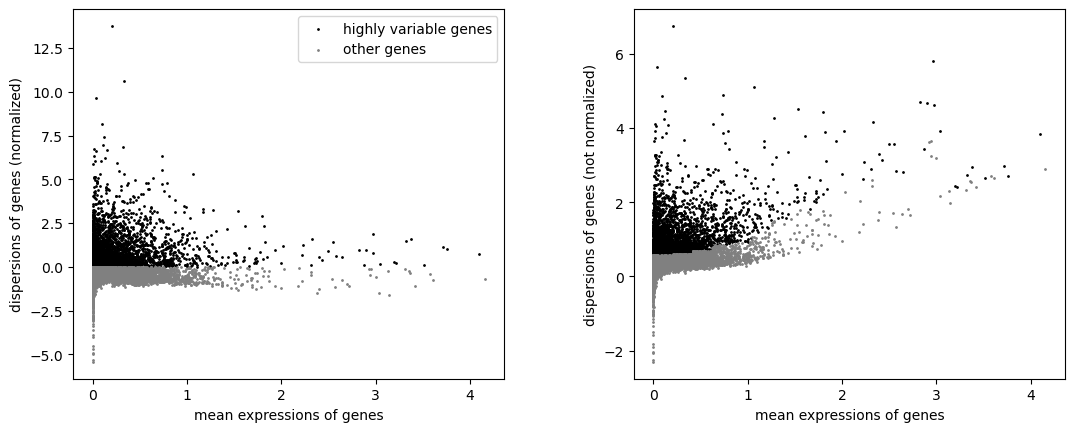

Finish Varible genes


In [132]:
run_preprocess(ea,top_genes=top_genes)

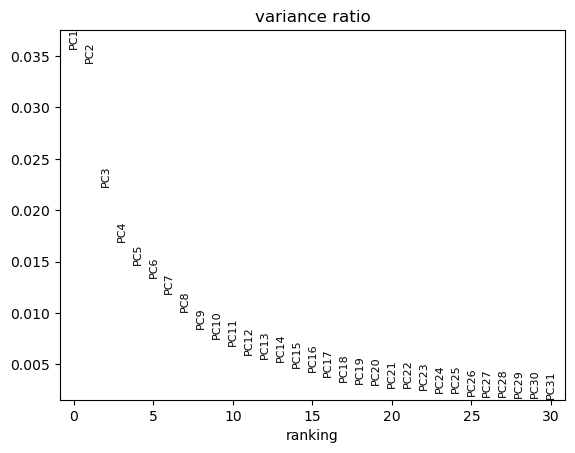

2025-03-05 14:49:20,080 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


skip scvi
running harmony


2025-03-05 14:49:24,571 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-03-05 14:49:24,654 - harmonypy - INFO - Iteration 1 of 10
2025-03-05 14:49:30,010 - harmonypy - INFO - Iteration 2 of 10
2025-03-05 14:49:35,510 - harmonypy - INFO - Iteration 3 of 10
2025-03-05 14:49:40,976 - harmonypy - INFO - Iteration 4 of 10
2025-03-05 14:49:46,465 - harmonypy - INFO - Converged after 4 iterations


finished harmony
Finish neighbors
Finish clustering
Finish UMAP


In [133]:
run_reduceDimension(ea,use_scvi=use_scvi,runharmony=runharmony,PCs=PCs,res=res)

In [134]:
if do_subset_cluster:
    ea = ea[~ea.obs['leiden'].isin(clusterlist)].copy()

In [135]:
ea = update_cell_annotations(ea, clustering_column='leiden', new_cell_type_dict=NewCellType, update_cell_type=update_cell_type)

In [28]:
ea.write(f'{dataset}_for_DEG.h5ad')

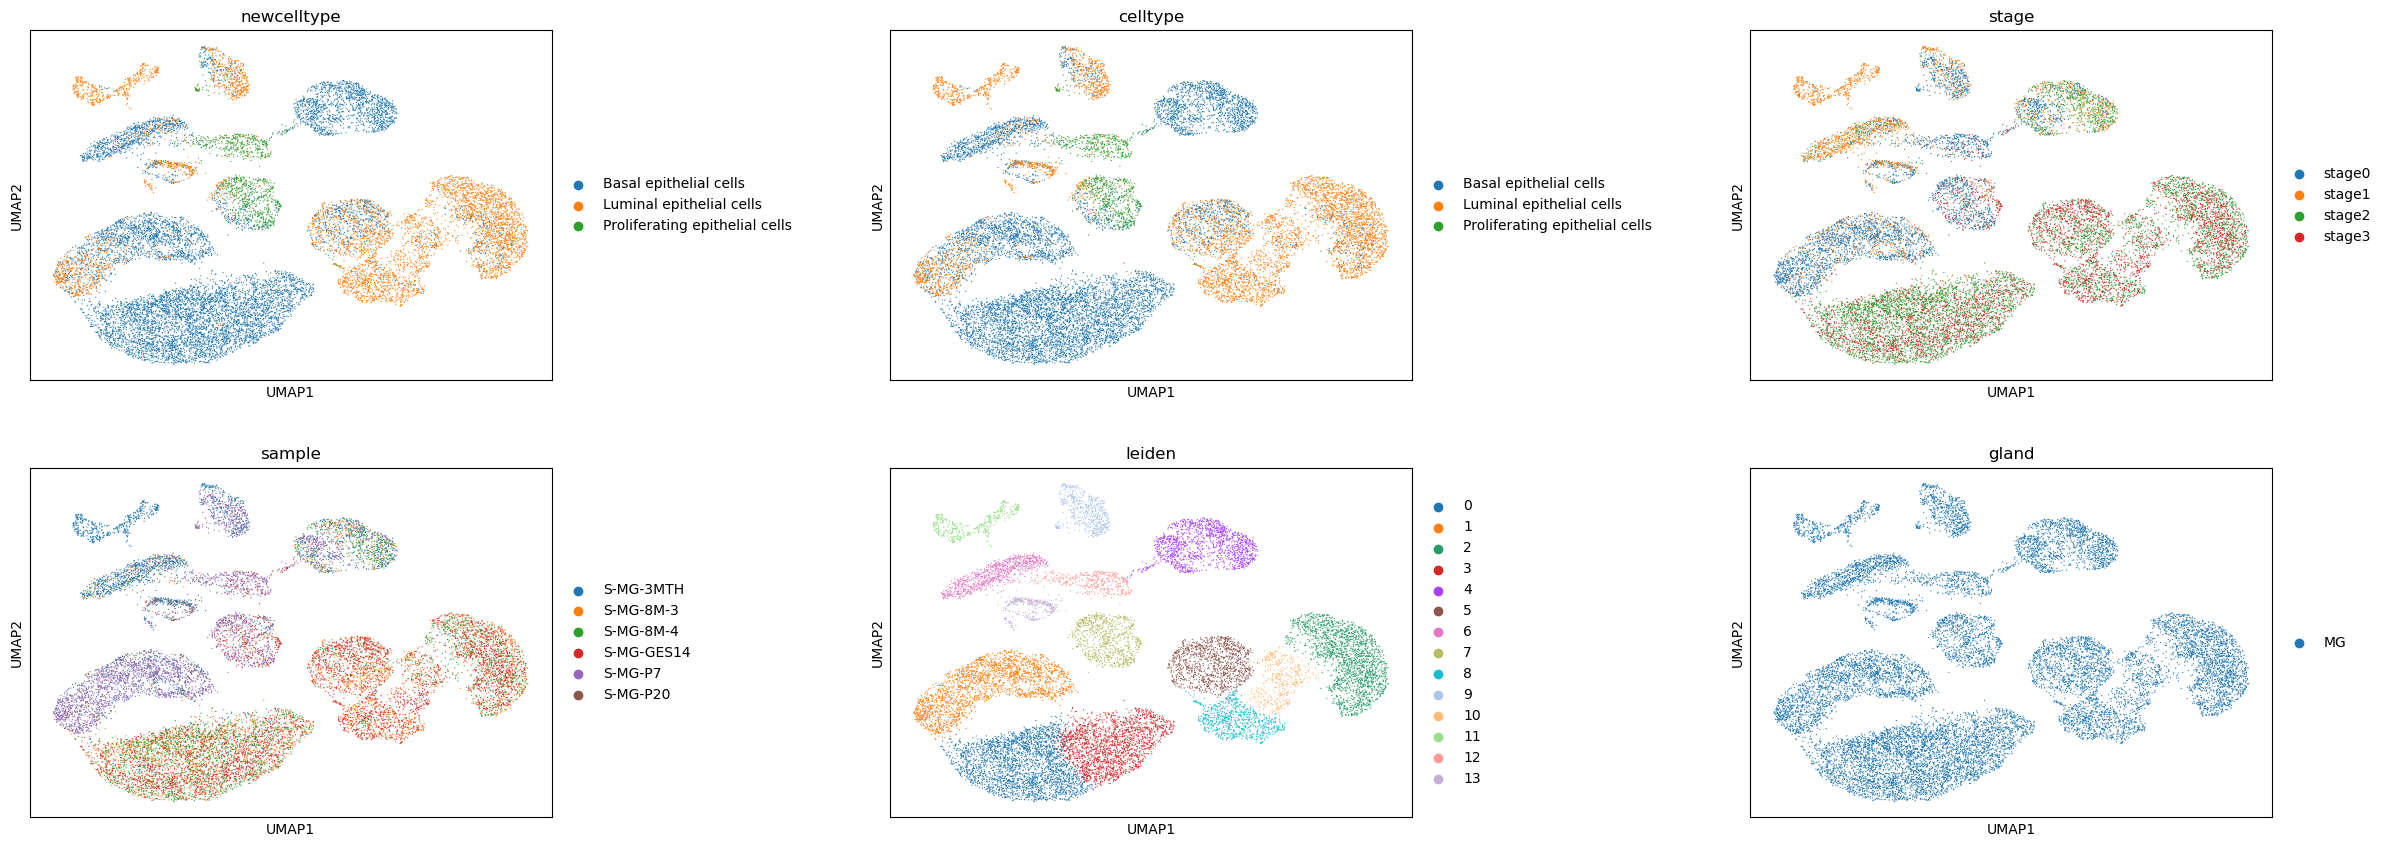

KeyboardInterrupt: 

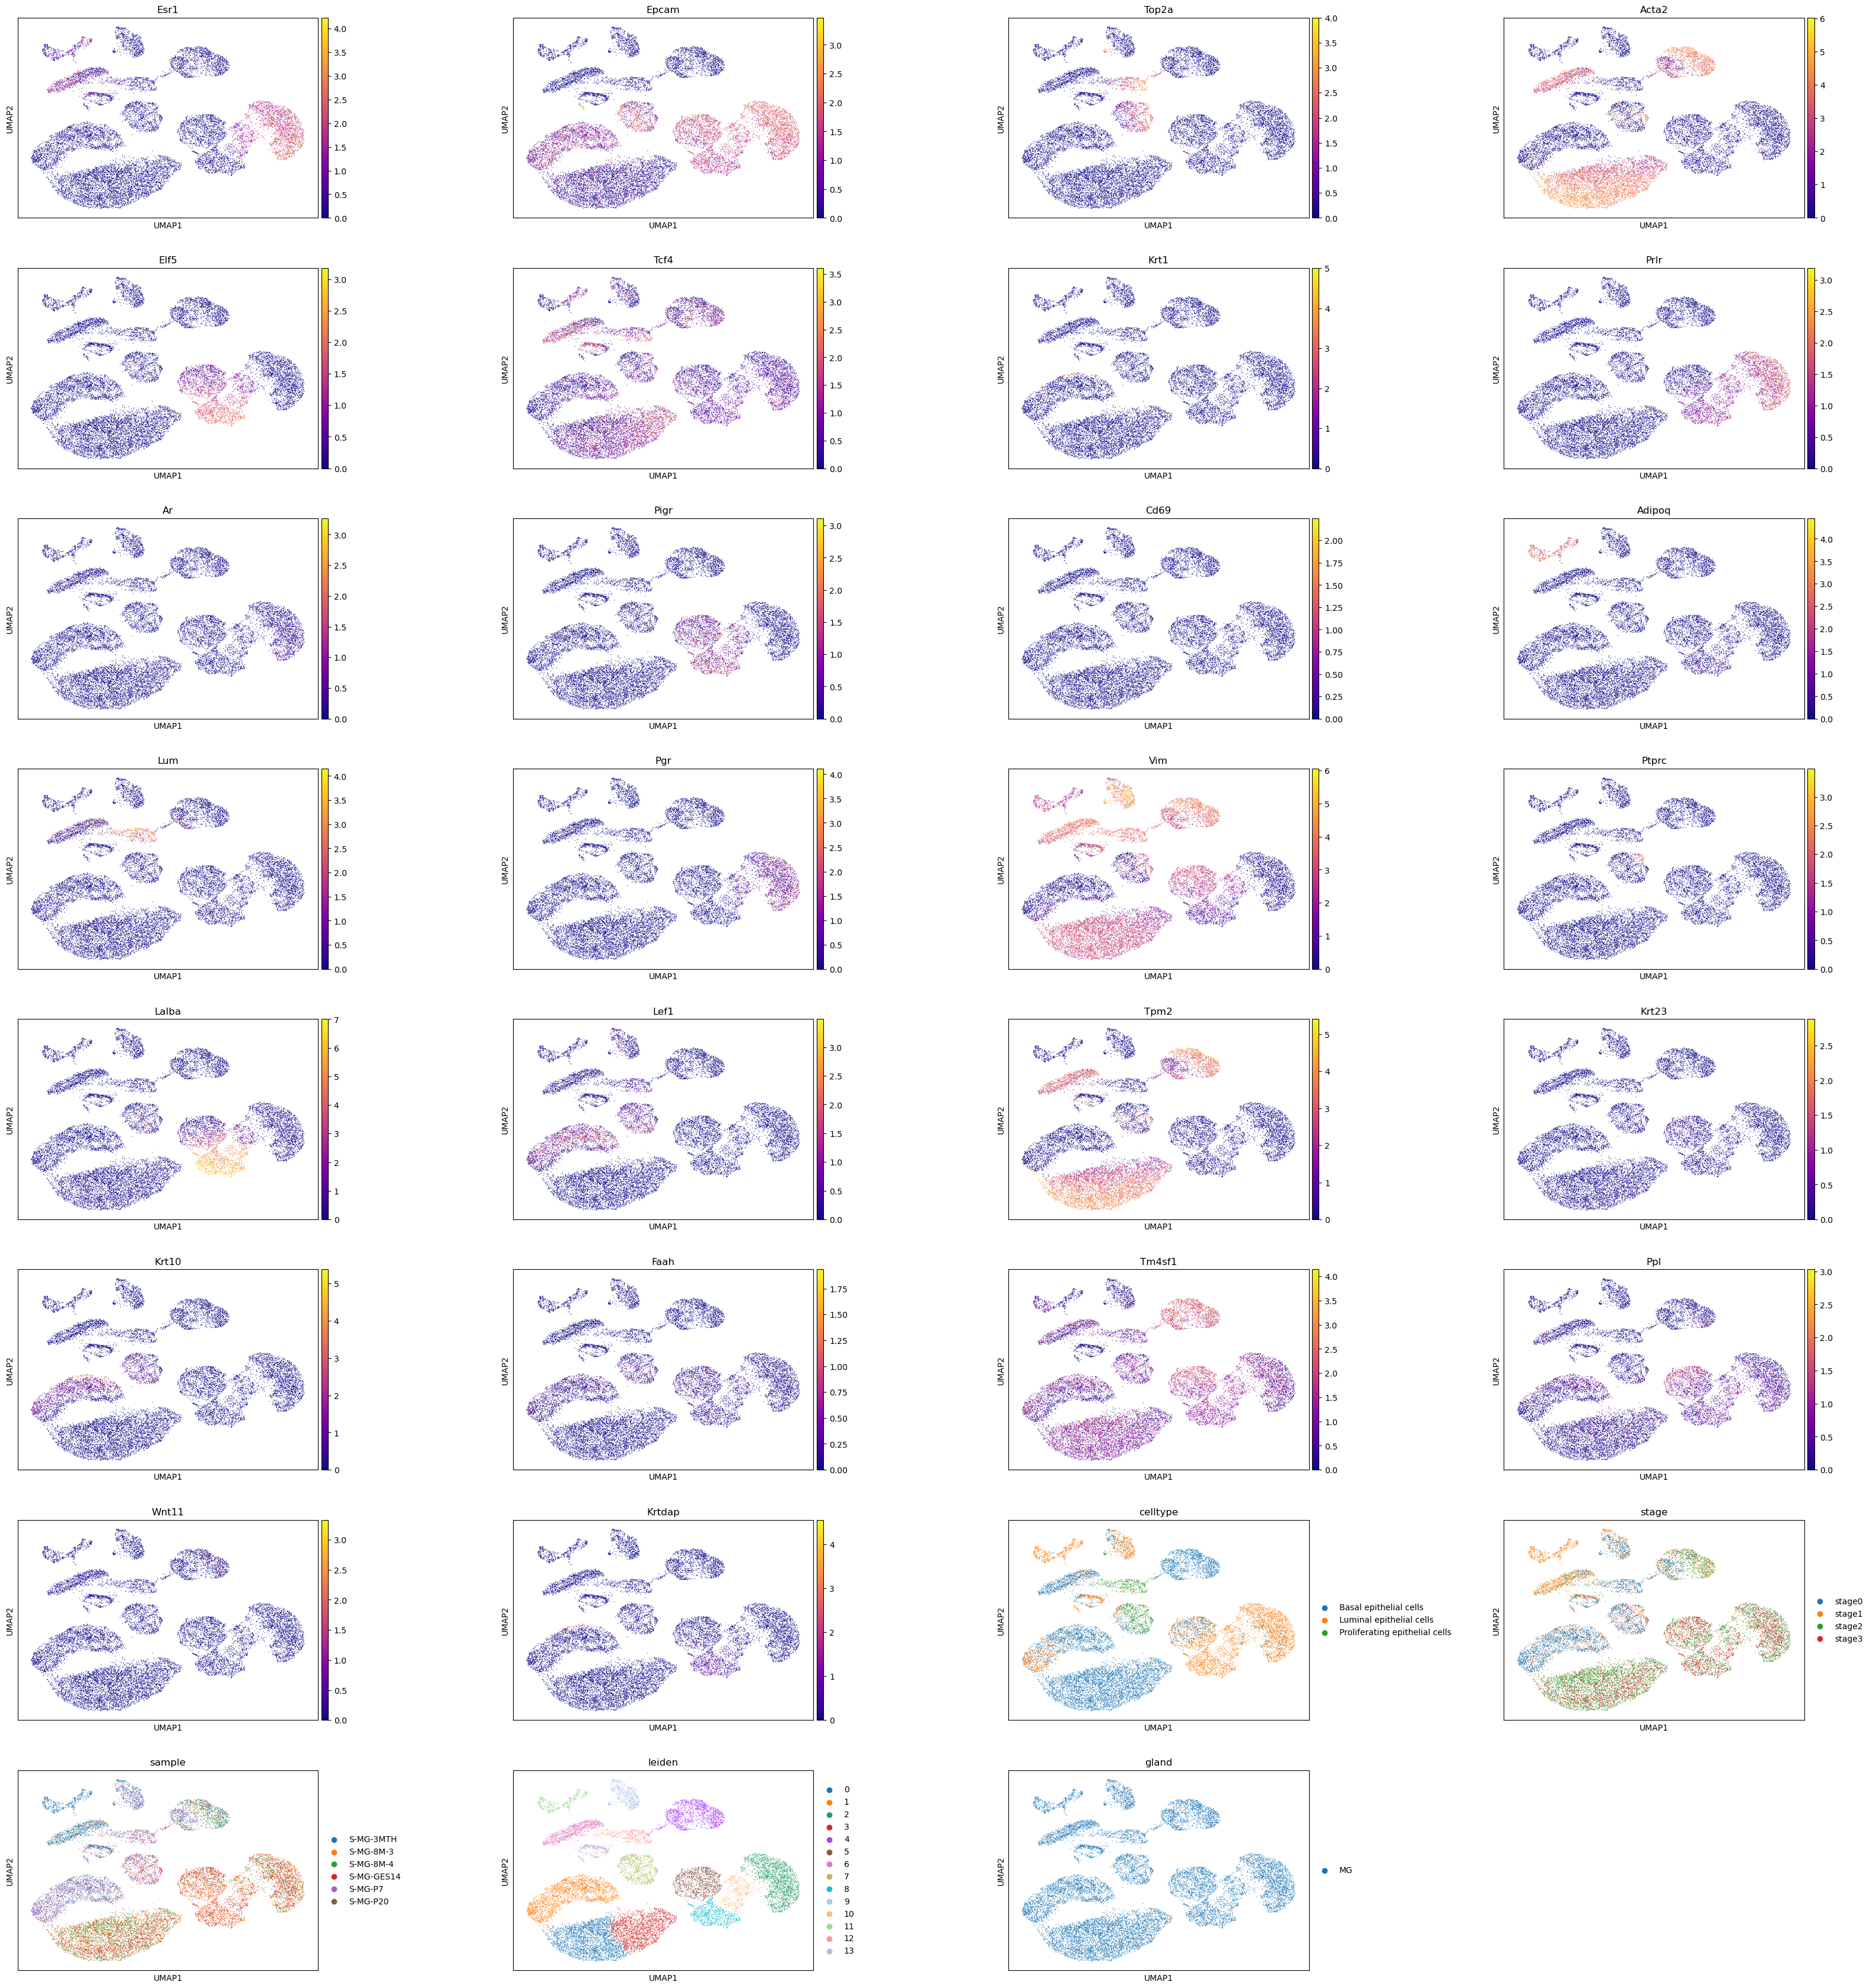

In [136]:
do_umap_plots(ea=ea,dataset=dataset,Featuregenes=Featuregenes,doFeatureplot=doFeatureplot)

In [ ]:
do_DEG(ea=ea,dataset=dataset)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_29648\2289866745.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  celltype_counts = ea.obs.groupby(['stage', 'newcelltype']).size().unstack(fill_value=0)


<Figure size 1400x800 with 0 Axes>

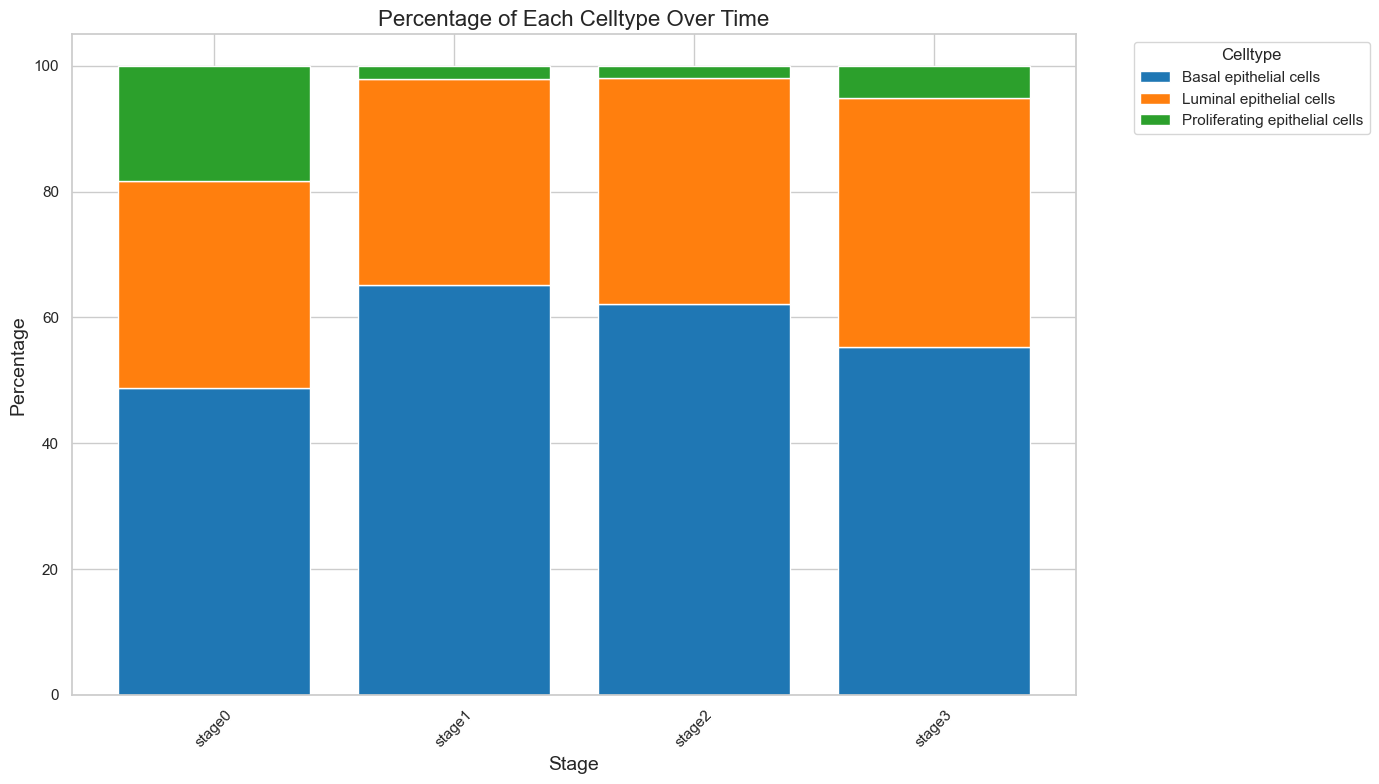

In [143]:
do_cell_barplot(ea=ea,dataset=dataset)